# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 1

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Mercado de ações (NYSE: The New York Stock Exchange)
#### Parcialmente baseado em https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Marcelo Eduardo Pederiva

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

D:\Anaconda3\envs\tf_gpu_2020\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# import all stock prices 
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['UNH', 'ALXN', 'HP', 'DE', 'AIZ', 'ACN', 'KMB', 'PBCT', 'PXD', 'XRAY']


,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


### 6.3. Exibindo o comportamento temporal de várias séries associadas à ação EQIX

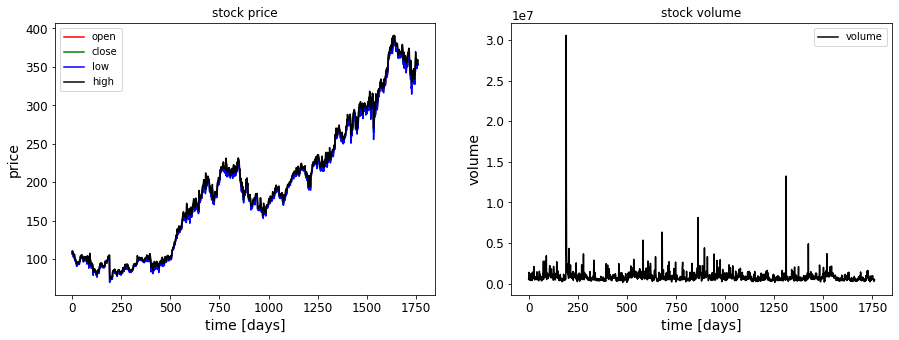

In [3]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

### 6.4. Escolha do preço de fechamento da ação EQIX e preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste
#### Cabe comentar que os dados de teste não deveriam participar de nenhuma etapa de pré-processamento, pois, assim, têm o potencial de interferir no andamento do treinamento, desvirtuando o seu papel de apenas servirem para teste de desempenho. Cometeremos essa "mancada" metodológica para despertar o(a) aluno(a) para a questão.

In [30]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = np.array(stock) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    # Choice of the close behavior
    
    x_train = data[:train_set_size,:-1,1]
    y_train = data[:train_set_size,-1,1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,1]
    
    x_test = data[train_set_size+valid_set_size:,:-1,1]
    y_test = data[train_set_size+valid_set_size:,-1,1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P1_x_train.txt', x_train)
    np.savetxt('Q6P1_y_train.txt', y_train)
    np.savetxt('Q6P1_x_valid.txt', x_valid)
    np.savetxt('Q6P1_y_valid.txt', y_valid)
    np.savetxt('Q6P1_x_test.txt', x_test)
    np.savetxt('Q6P1_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
print('Chosen stock is EQIX')
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols[1])

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
print(df_stock_norm)
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print(x_train[0])
print('y_train.shape = ', y_train.shape)
print(y_train[0])
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

Chosen stock is EQIX
df_stock.columns.values =  close
                open     close       low      high
date                                              
2010-01-04  0.109250  0.122904  0.117440  0.110911
2010-01-05  0.118896  0.119708  0.123361  0.110816
2010-01-06  0.116886  0.122810  0.122855  0.113912
2010-01-07  0.117828  0.115791  0.117852  0.113217
2010-01-08  0.110130  0.114161  0.115509  0.103519
...              ...       ...       ...       ...
2016-12-23  0.880884  0.897089  0.889589  0.895976
2016-12-27  0.895588  0.897433  0.904598  0.900745
2016-12-28  0.896971  0.888471  0.899278  0.900430
2016-12-29  0.885031  0.898593  0.894402  0.898471
2016-12-30  0.899893  0.899596  0.899436  0.896607

[1762 rows x 4 columns]
x_train.shape =  (1393, 20)
[0.12290433 0.11970795 0.12281032 0.1157908  0.11416126 0.11691894
 0.10325594 0.10259786 0.10585693 0.09955816 0.10526152 0.10375732
 0.10350664 0.08987496 0.09322804 0.0912538  0.09059573 0.0859265
 0.08113192 0.07994109]
y_trai

### 6.5. Visualização do comportamento da série temporal normalizada

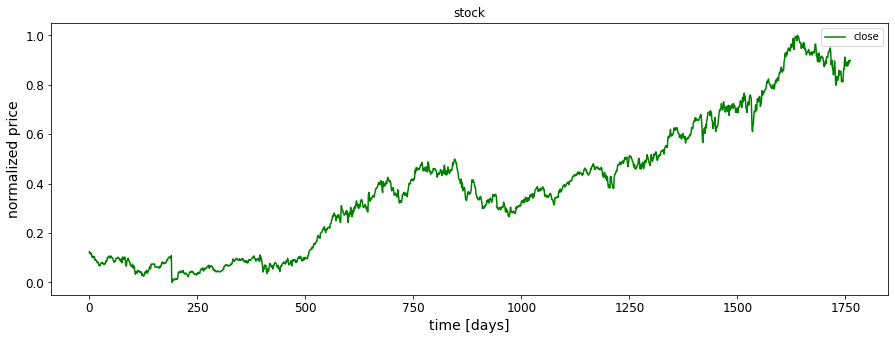

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-1.73993876e-02 -7.50066948e-04 -1.72042605e-02 -3.09133810e-03
  7.19680083e-02 -4.14608411e-02  6.27850574e-03  3.20712481e-02
 -5.12410805e-02 -4.49534424e-02  7.63970457e-02  2.38739465e-03
 -2.37630945e-02  4.03452307e-02  1.52671193e-03 -2.65006693e-02
  6.09614856e-02 -2.34004550e-02 -4.62112083e-03  9.62510603e-01
  0.00000000e+00]


#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
8.281533897781904e-05
EQM final de validação após o término do treinamento - Preditor Linear
0.00027770088993386247
EQM final de teste após o término do treinamento - Preditor Linear
0.00021231229767131773


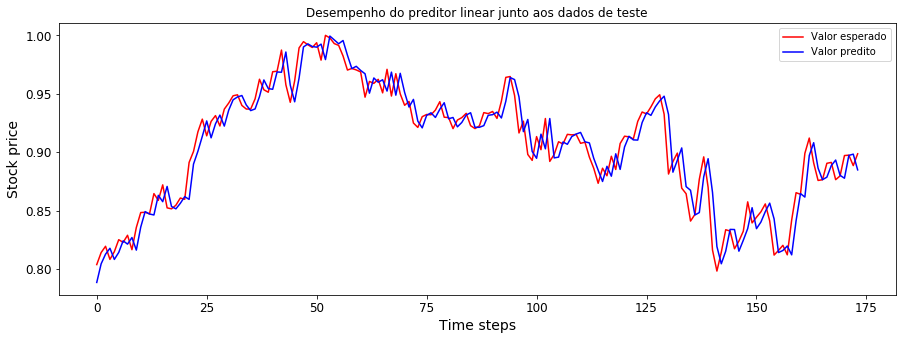

In [8]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [9]:
EPOCHS = 20
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Train on 1393 samples, validate on 174 samples
Epoch 1/20
1393/1393 [==============================] - 1s 701us/sample - loss: 0.0122 - val_loss: 0.0097
Epoch 2/20
1393/1393 [==============================] - 0s 87us/sample - loss: 4.2817e-04 - val_loss: 0.0047
Epoch 3/20
1393/1393 [==============================] - 0s 87us/sample - loss: 3.6534e-04 - val_loss: 0.00310
Epoch 4/20
1393/1393 [==============================] - 0s 85us/sample - loss: 3.0904e-04 - val_loss: 0.0030
Epoch 5/20
1393/1393 [==============================] - 0s 87us/sample - loss: 3.0999e-04 - val_loss: 0.0027
Epoch 6/20
1393/1393 [==============================] - 0s 86us/sample - loss: 2.5263e-04 - val_loss: 0.0018
Epoch 7/20
1393/1393 [==============================] - 0s 87us/sample - loss: 2.0976e-04 - val_loss: 0.0018
Epoch 8/20
1393/1393 [==============================] - 0s 85us/sample - loss: 1.9910e-04 - val_loss: 0.0017
Epoch 9/20
1393/1393 [==============================] - 0s 88us/sample - loss: 1.84

In [10]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2688      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

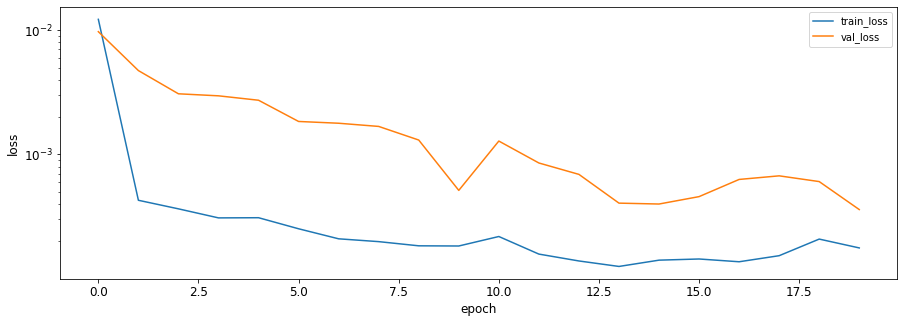

In [11]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [12]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.00012127537440833983
EQM final de validação após o término do treinamento - Preditor MLP
0.0003605459376102485
EQM final de teste após o término do treinamento - Preditor MLP
0.0006275413523062473


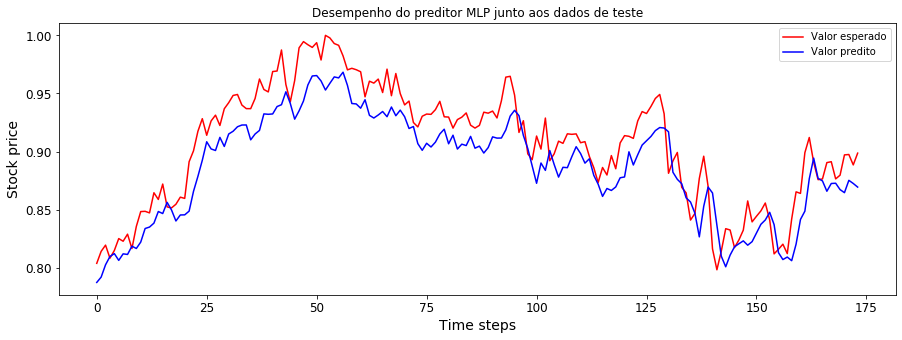

In [13]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [14]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)
Train on 1393 samples, validate on 174 samples
Epoch 1/20
1393/1393 [==============================] - 3s 2ms/sample - loss: 0.0219 - val_loss: 0.0036
Epoch 2/20
1393/1393 [==============================] - 1s 573us/sample - loss: 9.6917e-04 - val_loss: 0.0021
Epoch 3/20
1393/1393 [==============================] - 1s 555us/sample - loss: 7.8411e-04 - val_loss: 0.0032
Epoch 4/20
1393/1393 [==============================] - 1s 550us/sample - loss: 7.4032e-04 - val_loss: 0.0028
Epoch 5/20
1393/1393 [==============================] - 1s 549us/sample - loss: 6.9922e-04 - val_loss: 0.0027
Epoch 6/20
1393/1393 [==============================] - 1s 551us/sample - loss: 6.3871e-04 - val_loss: 0.0023
Epoch 7/20
1393/1393 [==============================] - 1s 544us/sample - loss: 6.0878e-04 - val_loss: 0.0028
Epoch 8/20
1393/1393 [==============================] - 1s 538us/sample - loss: 5.9442e-04 - val_loss: 0.0022
Epoch 9/20


In [15]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

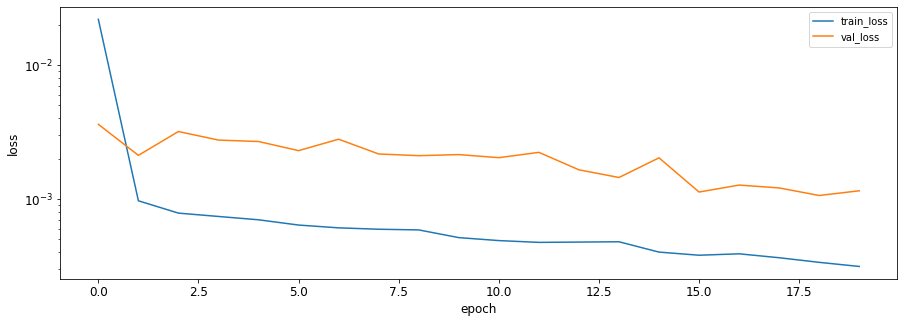

In [16]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [17]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.00032686766503403896
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.0010618316993033221
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.0064168124140177385


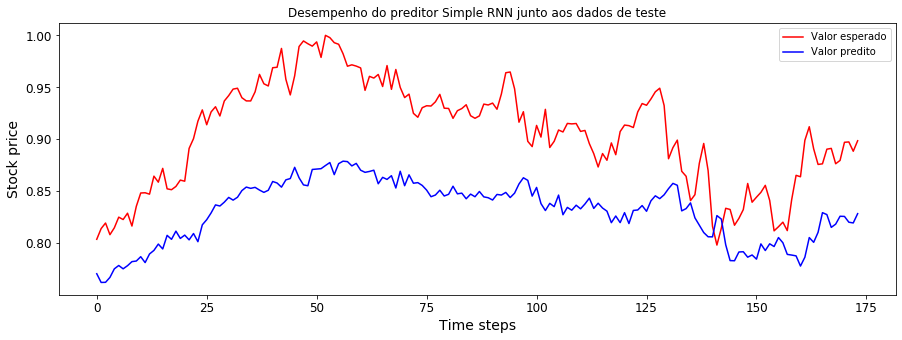

In [18]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [19]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(1393, 20, 1)
(1393, 1)
(174, 20, 1)
(174, 1)
(174, 20, 1)
(174, 1)
Train on 1393 samples, validate on 174 samples
Epoch 1/20
1393/1393 [==============================] - 5s 4ms/sample - loss: 0.0199 - val_loss: 0.0419
Epoch 2/20
1393/1393 [==============================] - 0s 194us/sample - loss: 0.0062 - val_loss: 0.0221
Epoch 3/20
1393/1393 [==============================] - 0s 197us/sample - loss: 0.0036 - val_loss: 0.0138
Epoch 4/20
1393/1393 [==============================] - 0s 216us/sample - loss: 0.0024 - val_loss: 0.0097
Epoch 5/20
1393/1393 [==============================] - 0s 195us/sample - loss: 0.0019 - val_loss: 0.0070
Epoch 6/20
1393/1393 [==============================] - 0s 191us/sample - loss: 0.0016 - val_loss: 0.0057
Epoch 7/20
1393/1393 [==============================] - 0s 200us/sample - loss: 0.0014 - val_loss: 0.0047
Epoch 8/20
1393/1393 [==============================] - 0s 199us/sample - loss: 0.0012 - val_loss: 0.0041
Epoch 9/20
1393/1393 [=================

In [20]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           21        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

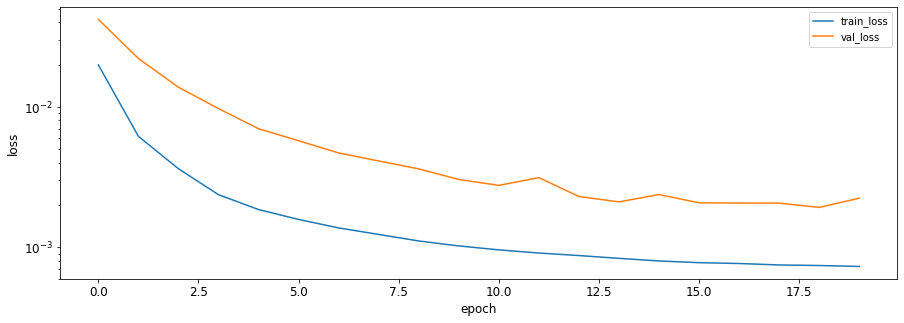

In [21]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [22]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
1393/1 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

EQM final de validação após o término do treinamento - Preditor LSTM GRU
174/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0023937767114618727

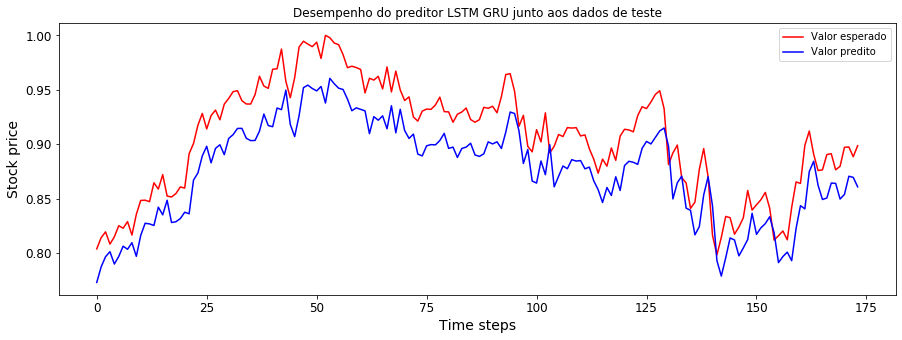

In [23]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len - 1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [24]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [25]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 5)             15        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [26]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Train on 1393 samples, validate on 174 samples
Epoch 1/20
1393/1393 [==============================] - 1s 709us/step - loss: 0.0361 - val_loss: 0.0479
Epoch 2/20
1393/1393 [==============================] - 0s 122us/step - loss: 0.0046 - val_loss: 0.0131
Epoch 3/20
1393/1393 [==============================] - 0s 121us/step - loss: 7.4375e-04 - val_loss: 0.0065
Epoch 4/20
1393/1393 [==============================] - 0s 133us/step - loss: 6.3306e-04 - val_loss: 0.0044
Epoch 5/20
1393/1393 [==============================] - 0s 127us/step - loss: 5.5694e-04 - val_loss: 0.0032
Epoch 6/20
1393/1393 [==============================] - 0s 134us/step - loss: 5.3579e-04 - val_loss: 0.0027
Epoch 7/20
1393/1393 [==============================] - 0s 120us/step - loss: 5.2521e-04 - val_loss: 0.0028
Epoch 8/20
1393/1393 [==============================] - 0s 130us/step - loss: 5.1018e-04 - val_loss: 0.0020
Epoch 9/20
1393/1393 [==============================] - 0s 129us/step - loss: 4.9415e-04 - val_lo

#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor CNN

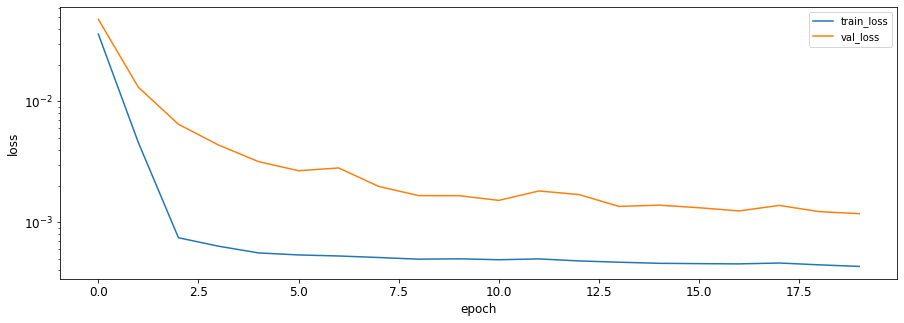

In [27]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [28]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.0004325605024082033
EQM final de validação após o término do treinamento - Preditor CNN
0.001177025597741044
EQM final de teste após o término do treinamento - Preditor CNN
0.004893898898232526


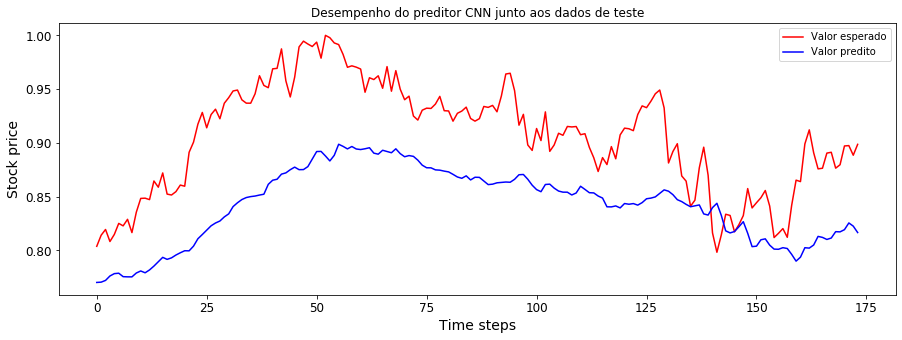

In [29]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

## Análise dos resultados

### 6.1.1
Nesta atividade estamos analisando os valores do mercado de ações e implementando diferentes modelos de predições de séries temporais nestes dados.

Inicialmente normalizamos os dados de entrada e definimos um conjunto de sequências de 20 valores para cada dataset (Treinamento, Validação e Teste).

Com os dados de treinamento representados em 1393 sequências de 20 valores, implementamos um preditor linear. Observando os resultados do preditor em um gráfico ao lado do valor esperado, observamos que o preditor obteve uma resposta similar ao esperado, entretanto com um atraso de um “step”.

Seguindo a atividade, é implementado 4 preditores não-lineares ( MLP, Simple RNN, LSTM GRU e CNN 1D).

Analisando os resultados gráficos, todos os métodos não-lineares apresentaram um “atraso” na variação de valores preditos comparados com as mudanças esperadas (Mesmo atraso encontrado no preditor linear). Além disso, os preditores não-lineares apresentaram uma falha no valor médio previsto, prevendo sempre um valor abaixo do que o valor esperado.

### 6.1.2

Analisando o Preditor Linear, observamos que a previsão sempre apresenta um valor próximo ao esperado do step anterior. Isso ocorre, pois ao sintetizar o preditor linear, os coeficientes estabelecem um peso maior para o último valor da sequência, dando mais relevância ao valor anterior ao da predição. Dessa forma, o modelo prevê um valor próximo ao anterior, resultando numa previsão “atrasada” dos valores esperados. Prevendo sempre uma pequena variação do último valor da sequência.

### 6.1.3

Como estamos trabalhando com uma base de dados de um mercado de ações, onde o próximo valor não depende do valor anterior e sim de diversos fatores externos. Os preditores não-lineares acabam por tentar gerar uma predição baseada no histórico de valores, resultando numa previsão errada dos futuros valores. 

Por outro lado, o preditor linear, por dar mais ênfase no último valor previsto e não aos valores anteriores, possui um resultado com um erro menor. Uma vez que os valores anteriores não influenciam no próximo “step”, a previsão do último valor conhecido se torna a melhor predição.

### 6.1.4

Verificando as curvas de treinamento dos preditores não-lineares observamos características de um modelo com underfitting, onde alguns modelos necessitariam mais epochs de treinamento e outros uma arquitetura diferente de rede neural [1]. Esta característica pode estar influenciando na predição dos valores próximos dos esperados gerando esta falha no offset das predições.

[1] - Long Short-Term Memory Networks With Python, Jason Brownlee, 2017